<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_kualitas_rendah1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fdf48825f10>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_bawah_i.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


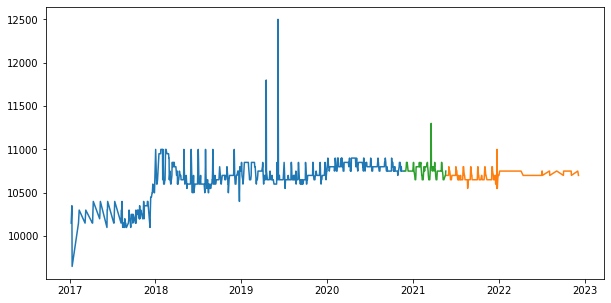

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [10]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

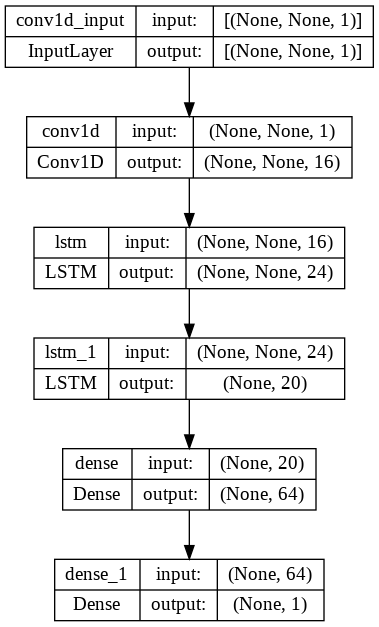

In [11]:
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [12]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 15s 48ms/step - loss: 0.1490 - mae: 0.3849 - mape: 94.5375 - val_loss: 0.0148 - val_mae: 0.1059 - val_mape: 9082102.0000
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.1012 - mae: 0.3169 - mape: 77.7845 - val_loss: 0.0077 - val_mae: 0.0727 - val_mape: 19190188.0000
Epoch 3/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0642 - mae: 0.2516 - mape: 61.7295 - val_loss: 0.0088 - val_mae: 0.0730 - val_mape: 29949896.0000
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0352 - mae: 0.1855 - mape: 45.4617 - val_loss: 0.0170 - val_mae: 0.1105 - val_mape: 39493820.0000
Epoch 5/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0180 - mae: 0.1320 - mape: 32.2849 - val_loss: 0.0278 - val_mae: 0.1475 - val_mape: 46657232.0000
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0091 - mae: 0.0931 - mape: 22.7228 - val_loss: 0.0381 - val_

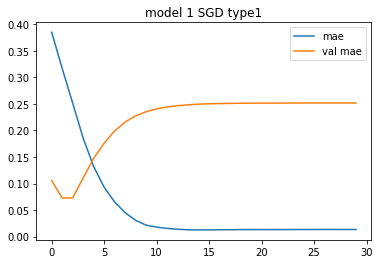

In [13]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_beras_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 8ms/step
105.11683 0.9845285 116.52900406792509


,date,actual,prediction
0,2021-05-20,10700,10806.489258
1,2021-05-21,10700,10807.310547
2,2021-05-24,10700,10805.952148
3,2021-05-25,10700,10806.826172
4,2021-05-27,10700,10805.453125
...,...,...,...
229,2022-11-02,10750,10804.471680
230,2022-11-03,10750,10805.016602
231,2022-11-04,10700,10804.632812
232,2022-12-01,10750,10805.210938


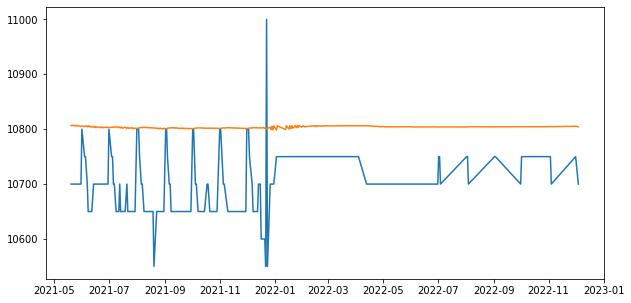

In [15]:
prediction = forecast_predict(model, test_beras_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras = pd.DataFrame()
data_new_beras['date'] = y_test
data_new_beras['actual'] = x_test
data_new_beras['prediction'] = data_result

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras.date, data_new_beras.actual)
plt.plot(data_new_beras.date, data_new_beras.prediction)
data_new_beras

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0306 - mape: 7.9344 - val_loss: 0.0655 - val_mae: 0.2416 - val_mape: 62482136.0000
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0302 - mape: 7.8059 - val_loss: 0.0650 - val_mae: 0.2406 - val_mape: 62323780.0000
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0300 - mape: 7.7387 - val_loss: 0.0653 - val_mae: 0.2413 - val_mape: 62437568.0000
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0297 - mape: 7.6753 - val_loss: 0.0657 - val_mae: 0.2421 - val_mape: 62564288.0000
Epoch 5/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0303 - mape: 7.8345 - val_loss: 0.0647 - val_mae: 0.2400 - val_mape: 62225144.0000
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0302 - mape: 7.8067 - val_loss: 0.0652 - val_

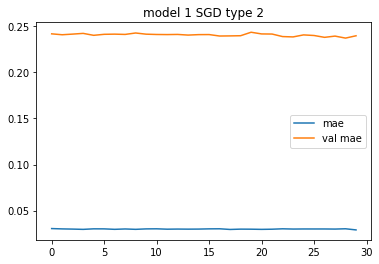

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
79.803185 0.74761605 92.05763098122284


,date,actual,prediction
0,2021-05-20,10700,10806.489258
1,2021-05-21,10700,10807.310547
2,2021-05-24,10700,10805.952148
3,2021-05-25,10700,10806.826172
4,2021-05-27,10700,10805.453125
...,...,...,...
229,2022-11-02,10750,10804.471680
230,2022-11-03,10750,10805.016602
231,2022-11-04,10700,10804.632812
232,2022-12-01,10750,10805.210938


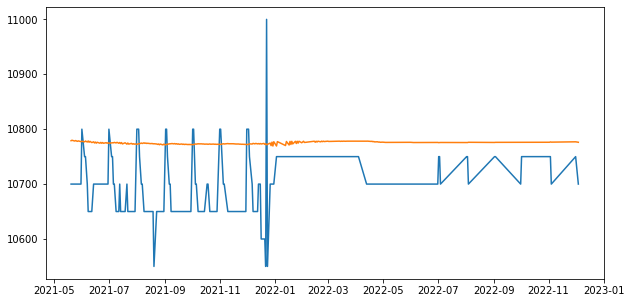

In [18]:
win_size1 = 60
test_beras_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_1 = pd.DataFrame()
data_new_beras_1['actual'] = x_test
data_new_beras_1['prediction'] = data_result_1

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_1.actual)
plt.plot(y_test, data_new_beras_1.prediction)
data_new_beras

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 18ms/step - loss: 0.0021 - mae: 0.0269 - mape: 6.8220 - val_loss: 0.0628 - val_mae: 0.2359 - val_mape: 61582752.0000
Epoch 2/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0020 - mae: 0.0266 - mape: 6.7034 - val_loss: 0.0615 - val_mae: 0.2332 - val_mape: 61142972.0000
Epoch 3/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0020 - mae: 0.0263 - mape: 6.5937 - val_loss: 0.0610 - val_mae: 0.2322 - val_mape: 60967176.0000
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0020 - mae: 0.0262 - mape: 6.5653 - val_loss: 0.0607 - val_mae: 0.2315 - val_mape: 60860228.0000
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0020 - mae: 0.0262 - mape: 6.5329 - val_loss: 0.0609 - val_mae: 0.2321 - val_mape: 60950772.0000
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0020 - mae: 0.0263 - mape: 6.5892 - val_loss: 0.0610 - val_mae: 0

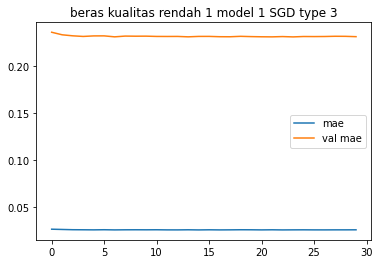

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
60.79018 0.5696609 75.50562957592136


,actual,prediction
0,10700,10757.278320
1,10700,10758.112305
2,10700,10756.674805
3,10700,10757.549805
4,10700,10756.086914
...,...,...
229,10750,10754.530273
230,10750,10755.108398
231,10700,10754.725586
232,10750,10755.341797


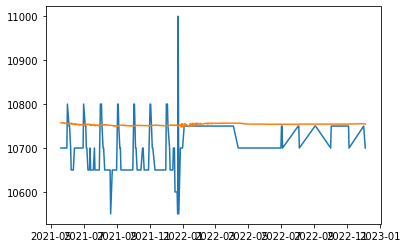

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_2['actual'] = x_test
data_new_beras_2['prediction'] = data_result_2

plt.plot(y_test, data_new_beras_2.actual)
plt.plot(y_test, data_new_beras_2.prediction)
data_new_beras_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 40ms/step - loss: 0.1192 - mae: 0.3429 - mape: 84.1731 - val_loss: 0.0104 - val_mae: 0.0873 - val_mape: 14247666.0000
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0342 - mae: 0.1691 - mape: 41.3108 - val_loss: 0.0169 - val_mae: 0.1097 - val_mape: 39514176.0000
Epoch 3/30
44/44 [==============================] - 1s 22ms/step - loss: 5.5805e-04 - mae: 0.0198 - mape: 4.8851 - val_loss: 0.0215 - val_mae: 0.1275 - val_mape: 42996356.0000
Epoch 4/30
44/44 [==============================] - 1s 22ms/step - loss: 3.0861e-04 - mae: 0.0148 - mape: 3.6238 - val_loss: 0.0220 - val_mae: 0.1290 - val_mape: 43295116.0000
Epoch 5/30
44/44 [==============================] - 1s 22ms/step - loss: 2.9385e-04 - mae: 0.0143 - mape: 3.5054 - val_loss: 0.0215 - val_mae: 0.1274 - val_mape: 42988260.0000
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 2.9831e-04 - mae: 0.0142 - mape: 3.4718 - val_loss: 0

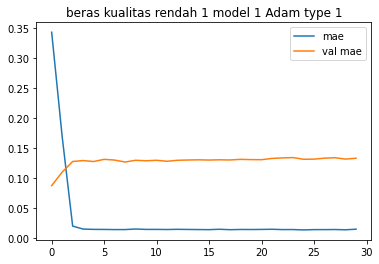

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
58.762367 0.5502561 70.66041700450118


,actual,prediction
0,10700,10788.917969
1,10700,10789.561523
2,10700,10787.181641
3,10700,10787.606445
4,10700,10784.996094
...,...,...
229,10750,10759.194336
230,10750,10759.972656
231,10700,10759.665039
232,10750,10760.560547


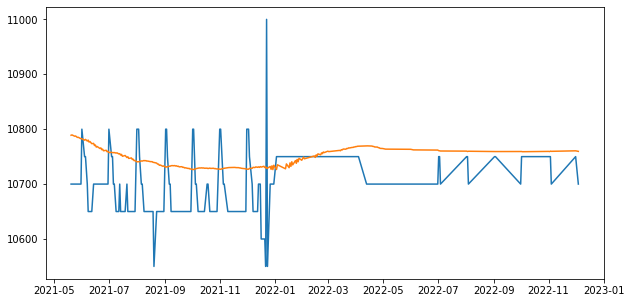

In [25]:
prediction_a = forecast_predict(model_a, test_beras_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_a = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a['actual'] = x_test
data_new_beras_a['prediction'] = data_result_a

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_a.actual)
plt.plot(y_test, data_new_beras_a.prediction)
data_new_beras_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0021 - mae: 0.0285 - mape: 7.2830 - val_loss: 0.0259 - val_mae: 0.1417 - val_mape: 45817032.0000
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0021 - mae: 0.0280 - mape: 7.1261 - val_loss: 0.0272 - val_mae: 0.1456 - val_mape: 46610052.0000
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0271 - mape: 6.9045 - val_loss: 0.0284 - val_mae: 0.1491 - val_mape: 47331240.0000
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0271 - mape: 6.8827 - val_loss: 0.0299 - val_mae: 0.1533 - val_mape: 48203900.0000
Epoch 5/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0019 - mae: 0.0269 - mape: 6.8490 - val_loss: 0.0321 - val_mae: 0.1593 - val_mape: 49357236.0000
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0019 - mae: 0.0268 - mape: 6.8316 - val_loss: 0.0334 - val_

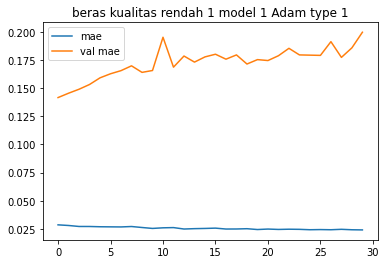

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
91.97 0.861065 100.76402953652409


,actual,prediction
0,10700,10825.468750
1,10700,10825.181641
2,10700,10823.085938
3,10700,10822.084961
4,10700,10819.812500
...,...,...
229,10750,10794.621094
230,10750,10795.650391
231,10700,10796.219727
232,10750,10797.373047


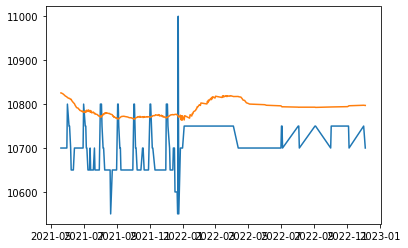

In [28]:
prediction_a1 = forecast_predict(model_a, test_beras_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_a1 = pd.DataFrame()
data_new_beras_a1['actual'] = x_test
data_new_beras_a1['prediction'] = data_result_a1

plt.plot(y_test, data_new_beras_a1.actual)
plt.plot(y_test, data_new_beras_a1.prediction)
data_new_beras_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0018 - mae: 0.0204 - mape: 5.0229 - val_loss: 0.0442 - val_mae: 0.1917 - val_mape: 55027000.0000
Epoch 2/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0018 - mae: 0.0199 - mape: 4.8600 - val_loss: 0.0425 - val_mae: 0.1874 - val_mape: 54305440.0000
Epoch 3/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0018 - mae: 0.0199 - mape: 4.8771 - val_loss: 0.0399 - val_mae: 0.1803 - val_mape: 53164884.0000
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0018 - mae: 0.0195 - mape: 4.7691 - val_loss: 0.0388 - val_mae: 0.1771 - val_mape: 52652732.0000
Epoch 5/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0017 - mae: 0.0191 - mape: 4.6576 - val_loss: 0.0385 - val_mae: 0.1762 - val_mape: 52493816.0000
Epoch 6/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0018 - mae: 0.0194 - mape: 4.7184 - val_loss: 0.0387 - val_mae: 0

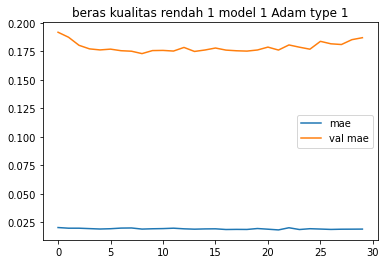

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 7ms/step
47.499416 0.44428253 58.57361529053098


,actual,prediction
0,10700,10780.244141
1,10700,10778.108398
2,10700,10777.833984
3,10700,10774.832031
4,10700,10774.321289
...,...,...
229,10750,10742.676758
230,10750,10742.232422
231,10700,10743.632812
232,10750,10743.280273


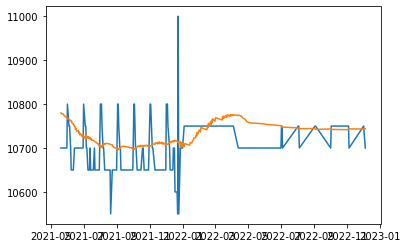

In [31]:
prediction_a2 = forecast_predict(model_a, test_beras_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_a2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a2['actual'] = x_test
data_new_beras_a2['prediction'] = data_result_a2

plt.plot(y_test, data_new_beras_a2.actual)
plt.plot(y_test, data_new_beras_a2.prediction)
data_new_beras_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 48ms/step - loss: 0.0193 - mae: 0.0831 - mape: 20.3284 - val_loss: 0.0368 - val_mae: 0.1723 - val_mape: 51399896.0000
Epoch 2/100
44/44 [==============================] - 1s 23ms/step - loss: 2.8248e-04 - mae: 0.0135 - mape: 3.2971 - val_loss: 0.0328 - val_mae: 0.1614 - val_mape: 49422148.0000
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 3.2933e-04 - mae: 0.0147 - mape: 3.6020 - val_loss: 0.0342 - val_mae: 0.1654 - val_mape: 50147736.0000
Epoch 4/100
44/44 [==============================] - 1s 24ms/step - loss: 3.7900e-04 - mae: 0.0160 - mape: 3.9246 - val_loss: 0.0378 - val_mae: 0.1751 - val_mape: 51873592.0000
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 3.6085e-04 - mae: 0.0150 - mape: 3.6729 - val_loss: 0.0398 - val_mae: 0.1807 - val_mape: 52764980.0000
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 3.2131e-04 - mae: 0.0145 - mape: 3.5646 - va

17/17 [==============================] - 0s 7ms/step - loss: 0.0026 - mae: 0.0488 - mape: 12.5498


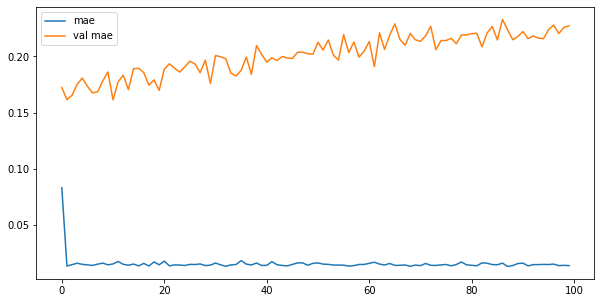

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras1 = pd.DataFrame()
data_new_beras1['actual'] = x_test
data_new_beras1['prediction'] = data_result1

data_new_beras1

131/131 [==============================] - 2s 8ms/step
96.824234 0.9068676 107.8555620523346


,actual,prediction
0,10700,10804.541016
1,10700,10804.263672
2,10700,10804.019531
3,10700,10803.616211
4,10700,10803.252930
...,...,...
229,10750,10796.222656
230,10750,10796.426758
231,10700,10796.722656
232,10750,10796.955078


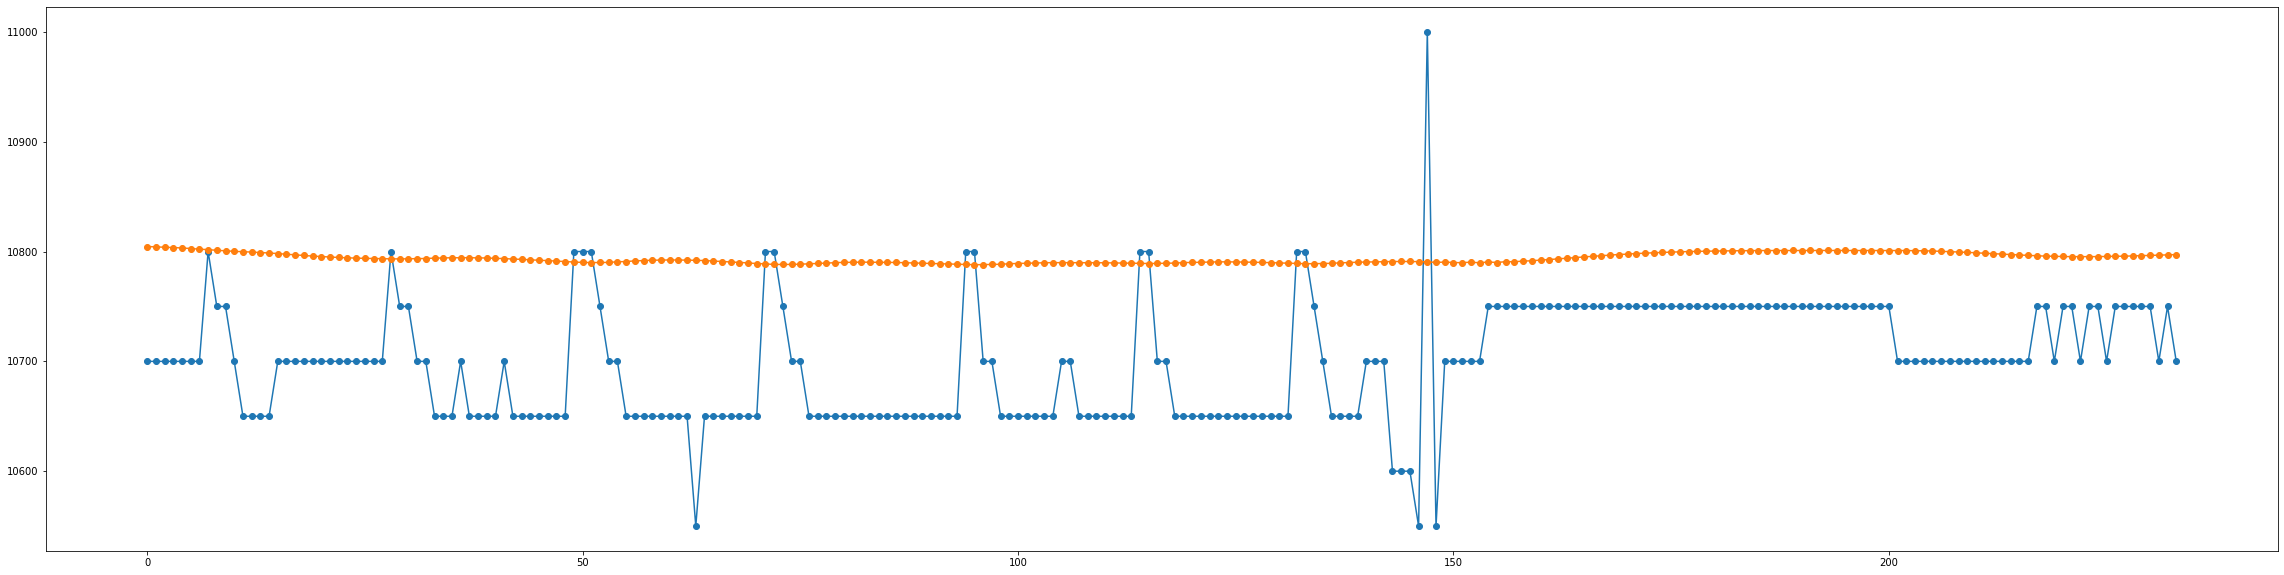

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0024 - mae: 0.0320 - mape: 8.2403 - val_loss: 0.0695 - val_mae: 0.2498 - val_mape: 63834236.0000
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0022 - mae: 0.0301 - mape: 7.7223 - val_loss: 0.0713 - val_mae: 0.2534 - val_mape: 64428476.0000
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0020 - mae: 0.0283 - mape: 7.2650 - val_loss: 0.0674 - val_mae: 0.2456 - val_mape: 63123028.0000
Epoch 4/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0021 - mae: 0.0292 - mape: 7.5109 - val_loss: 0.0744 - val_mae: 0.2594 - val_mape: 65350032.0000
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0021 - mae: 0.0302 - mape: 7.7495 - val_loss: 0.0690 - val_mae: 0.2487 - val_mape: 63631216.0000
Epoch 6/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0021 - mae: 0.0302 - mape: 7.7553 - val_loss: 0.0709 - 

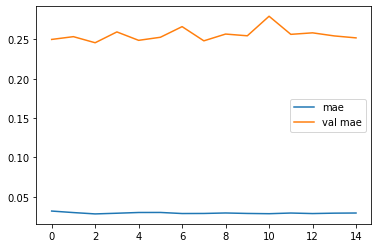

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
81.13141 0.76011175 107.8555620523346


,actual,prediction
0,10700,10776.625
1,10700,10776.625
2,10700,10776.625
3,10700,10776.625
4,10700,10776.625
...,...,...
229,10750,10776.625
230,10750,10776.625
231,10700,10776.625
232,10750,10776.625


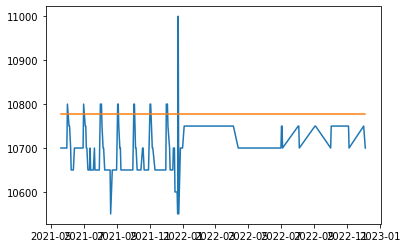

In [39]:
prediction1_1 = forecast_predict(model1, test_beras_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras1_1 = pd.DataFrame()
data_new_beras1_1['actual'] = x_test
data_new_beras1_1['prediction'] = data_result1_1

plt.plot(y_test, data_new_beras1_1.actual)
plt.plot(y_test, data_new_beras1_1.prediction)
data_new_beras1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0021 - mae: 0.0276 - mape: 6.9211 - val_loss: 0.0671 - val_mae: 0.2450 - val_mape: 62992452.0000
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0021 - mae: 0.0276 - mape: 6.9080 - val_loss: 0.0630 - val_mae: 0.2366 - val_mape: 61620868.0000
Epoch 3/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0021 - mae: 0.0273 - mape: 6.8412 - val_loss: 0.0664 - val_mae: 0.2435 - val_mape: 62741088.0000
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0021 - mae: 0.0272 - mape: 6.8131 - val_loss: 0.0695 - val_mae: 0.2498 - val_mape: 63775620.0000
Epoch 5/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0021 - mae: 0.0272 - mape: 6.8101 - val_loss: 0.0680 - val_mae: 0.2467 - val_mape: 63268496.0000
Epoch 6/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0021 - mae: 0.0271 - mape: 6.7955 - val_loss: 0.0633 - val_mae: 0

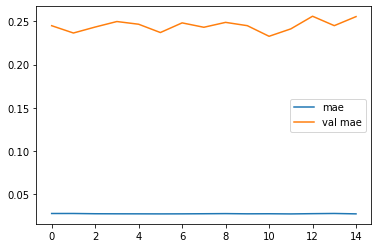

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
90.47988 0.8476085 107.8555620523346


,actual,prediction
0,10700,10787.244141
1,10700,10787.244141
2,10700,10787.244141
3,10700,10787.244141
4,10700,10787.244141
...,...,...
229,10750,10787.244141
230,10750,10787.244141
231,10700,10787.244141
232,10750,10787.244141


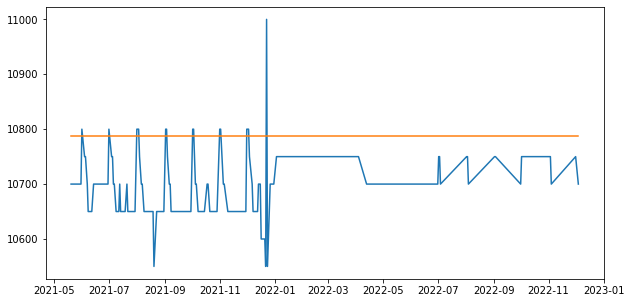

In [44]:
prediction1_2 = forecast_predict(model1, test_beras_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras1_2 = pd.DataFrame()
data_new_beras1_2['actual'] = x_test
data_new_beras1_2['prediction'] = data_result1_2

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_2.actual)
plt.plot(y_test, data_new_beras1_2.prediction)

data_new_beras1_2

### SGD

In [45]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [46]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 44ms/step - loss: 0.1369 - mae: 0.3691 - mape: 90.6689 - val_loss: 0.0151 - val_mae: 0.1071 - val_mape: 8838933.0000
Epoch 2/15
44/44 [==============================] - 1s 28ms/step - loss: 0.0998 - mae: 0.3150 - mape: 77.3528 - val_loss: 0.0093 - val_mae: 0.0824 - val_mape: 15828800.0000
Epoch 3/15
44/44 [==============================] - 1s 33ms/step - loss: 0.0736 - mae: 0.2704 - mape: 66.3811 - val_loss: 0.0072 - val_mae: 0.0659 - val_mape: 21673122.0000
Epoch 4/15
44/44 [==============================] - 2s 43ms/step - loss: 0.0542 - mae: 0.2318 - mape: 56.8901 - val_loss: 0.0076 - val_mae: 0.0623 - val_mape: 26919978.0000
Epoch 5/15
44/44 [==============================] - 2s 37ms/step - loss: 0.0399 - mae: 0.1989 - mape: 48.7845 - val_loss: 0.0096 - val_mae: 0.0785 - val_mape: 31541884.0000
Epoch 6/15
44/44 [==============================] - 2s 37ms/step - loss: 0.0295 - mae: 0.1706 - mape: 41.8211 - val_loss: 0.0128 - val_m

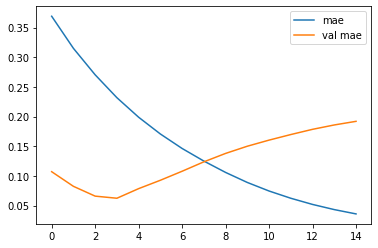

In [47]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 9ms/step
90.47988 0.8476085 102.76311979043113


,actual,prediction
0,10700,10787.244141
1,10700,10787.244141
2,10700,10787.244141
3,10700,10787.244141
4,10700,10787.244141
...,...,...
229,10750,10787.244141
230,10750,10787.244141
231,10700,10787.244141
232,10750,10787.244141


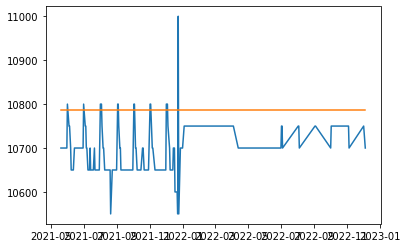

In [49]:
prediction1_a = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = x_test
data_new_beras1_a['prediction'] = data_result1_a


plt.plot(y_test, data_new_beras1_a.actual)
plt.plot(y_test, data_new_beras1_a.prediction)

data_new_beras1_a

#### Type 2


In [50]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0020 - mae: 0.0280 - mape: 7.0316 - val_loss: 0.0514 - val_mae: 0.2104 - val_mape: 57553568.0000
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0020 - mae: 0.0300 - mape: 7.7179 - val_loss: 0.0512 - val_mae: 0.2100 - val_mape: 57491524.0000
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0020 - mae: 0.0296 - mape: 7.6096 - val_loss: 0.0517 - val_mae: 0.2111 - val_mape: 57675332.0000
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0020 - mae: 0.0297 - mape: 7.6621 - val_loss: 0.0513 - val_mae: 0.2101 - val_mape: 57502520.0000
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0020 - mae: 0.0298 - mape: 7.6871 - val_loss: 0.0511 - val_mae: 0.2096 - val_mape: 57435164.0000
Epoch 6/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0020 - mae: 0.0297 - mape: 7.6508 - val_loss: 0.0515 - v

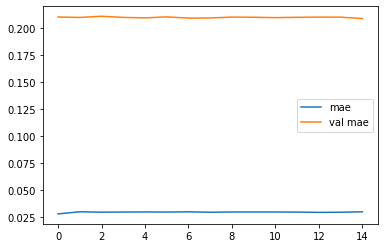

In [51]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
54.946747 0.51479596 68.92939662255866


,actual,prediction
0,10700,10757.740234
1,10700,10757.505859
2,10700,10757.263672
3,10700,10756.925781
4,10700,10756.536133
...,...,...
229,10750,10747.392578
230,10750,10747.476562
231,10700,10747.667969
232,10750,10747.816406


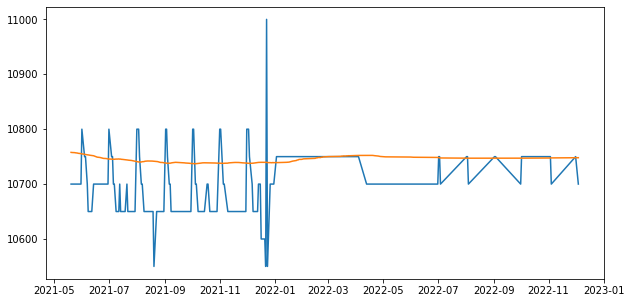

In [52]:
prediction1_a1 = forecast_predict(model1_a, test_beras_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras1_a1 = pd.DataFrame()
data_new_beras1_a1['actual'] = x_test
data_new_beras1_a1['prediction'] = data_result1_a1

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a1.actual)
plt.plot(y_test, data_new_beras1_a1.prediction)
data_new_beras1_a1

#### Type 3

In [53]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 20ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2792 - val_loss: 0.0506 - val_mae: 0.2086 - val_mape: 57270824.0000
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0020 - mae: 0.0250 - mape: 6.2555 - val_loss: 0.0504 - val_mae: 0.2079 - val_mape: 57158468.0000
Epoch 3/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0020 - mae: 0.0250 - mape: 6.2522 - val_loss: 0.0505 - val_mae: 0.2082 - val_mape: 57199020.0000
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0020 - mae: 0.0249 - mape: 6.2338 - val_loss: 0.0503 - val_mae: 0.2078 - val_mape: 57133920.0000
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0020 - mae: 0.0250 - mape: 6.2383 - val_loss: 0.0501 - val_mae: 0.2073 - val_mape: 57065028.0000
Epoch 6/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0020 - mae: 0.0249 - mape: 6.1988 - val_loss: 0.0501 - val_mae: 0

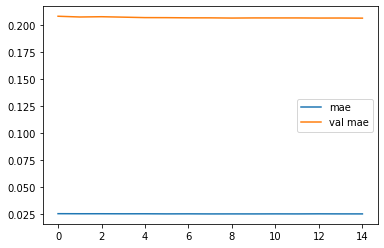

In [54]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
56.64952 0.5307885 70.92144297896617


,actual,prediction
0,10700,10761.090820
1,10700,10760.849609
2,10700,10760.610352
3,10700,10760.267578
4,10700,10759.891602
...,...,...
229,10750,10750.486328
230,10750,10750.569336
231,10700,10750.770508
232,10750,10750.914062


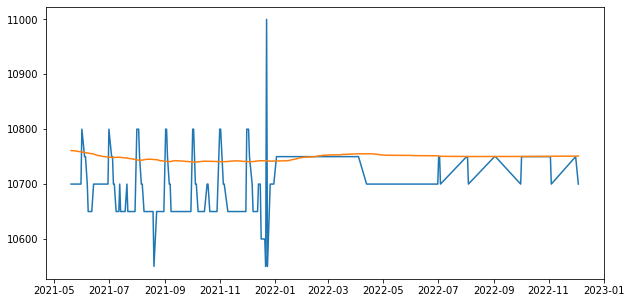

In [56]:
prediction1_a2 = forecast_predict(model1_a, test_beras_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras1_a2 = pd.DataFrame()
data_new_beras1_a2['actual'] = x_test
data_new_beras1_a2['prediction'] = data_result1_a2

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a2.actual)
plt.plot(y_test, data_new_beras1_a2.prediction)

data_new_beras1_a2

## model 2

### SGD

In [57]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [58]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 4s 35ms/step - loss: 0.1674 - mae: 0.4088 - val_loss: 0.0279 - val_mae: 0.1442
Epoch 2/100
44/44 [==============================] - 1s 25ms/step - loss: 0.1673 - mae: 0.4087 - val_loss: 0.0279 - val_mae: 0.1442
Epoch 3/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1672 - mae: 0.4085 - val_loss: 0.0278 - val_mae: 0.1441
Epoch 4/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1672 - mae: 0.4085 - val_loss: 0.0278 - val_mae: 0.1440
Epoch 5/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1671 - mae: 0.4085 - val_loss: 0.0278 - val_mae: 0.1439
Epoch 6/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1671 - mae: 0.4084 - val_loss: 0.0278 - val_mae: 0.1439
Epoch 7/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1670 - mae: 0.4083 - val_loss: 0.0278 - val_mae: 0.1438
Epoch 8/100
44/44 [==============================] - 1s 16ms/step - loss: 0.

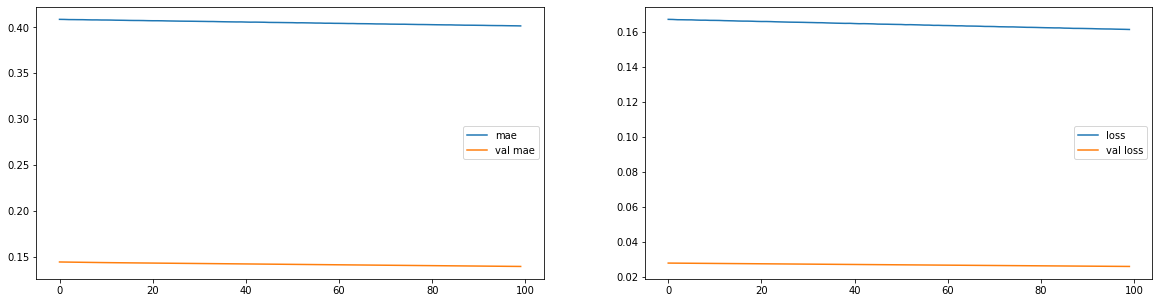

In [59]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1034.2909 9.663949 1035.7175652657436


,actual,prediction
0,10700,9665.355469
1,10700,9665.410156
2,10700,9665.348633
3,10700,9665.433594
4,10700,9665.379883
...,...,...
229,10750,9665.669922
230,10750,9665.724609
231,10700,9665.652344
232,10750,9665.698242


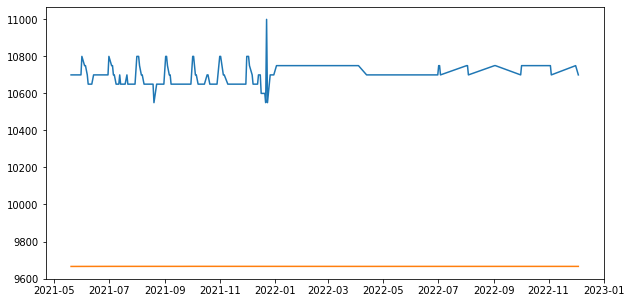

In [60]:
prediction2 = forecast_predict(model2, test_beras_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = x_test
data_new_beras2['prediction'] = data_result2

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras2.actual)
plt.plot(y_test, data_new_beras2.prediction)
data_new_beras2

#### Type2

In [61]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1437 - mae: 0.3764 - val_loss: 0.0257 - val_mae: 0.1387
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1429 - mae: 0.3753 - val_loss: 0.0254 - val_mae: 0.1380
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1421 - mae: 0.3742 - val_loss: 0.0251 - val_mae: 0.1373
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1414 - mae: 0.3732 - val_loss: 0.0249 - val_mae: 0.1366
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1406 - mae: 0.3721 - val_loss: 0.0246 - val_mae: 0.1359
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1398 - mae: 0.3711 - val_loss: 0.0243 - val_mae: 0.1352
Epoch 7/50
718/718 [==============================] - 6s 8ms/step - loss: 0.1390 - mae: 0.3700 - val_loss: 0.0241 - val_mae: 0.1345
Epoch 8/50
718/718 [==============================] - 6s 8ms/step - loss: 0.

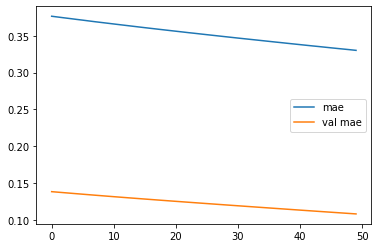

In [62]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [63]:
prediction2_1 = forecast_predict(model2, test_beras_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras2_1 = pd.DataFrame()
data_new_beras2_1['actual'] = x_test
data_new_beras2_1['prediction'] = data_result2_1

data_new_beras2

199/199 [==============================] - 1s 4ms/step
900.7835 8.416187 902.4162010957028


,actual,prediction
0,10700,9665.355469
1,10700,9665.410156
2,10700,9665.348633
3,10700,9665.433594
4,10700,9665.379883
...,...,...
229,10750,9665.669922
230,10750,9665.724609
231,10700,9665.652344
232,10750,9665.698242


#### Type 3

In [64]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 14ms/step - loss: 0.1148 - mae: 0.3357 - val_loss: 0.0155 - val_mae: 0.1084
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1147 - mae: 0.3356 - val_loss: 0.0155 - val_mae: 0.1084
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1146 - mae: 0.3355 - val_loss: 0.0155 - val_mae: 0.1083
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1146 - mae: 0.3354 - val_loss: 0.0154 - val_mae: 0.1082
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1145 - mae: 0.3353 - val_loss: 0.0154 - val_mae: 0.1082
Epoch 6/50
84/84 [==============================] - 1s 13ms/step - loss: 0.1144 - mae: 0.3352 - val_loss: 0.0154 - val_mae: 0.1081
Epoch 7/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1143 - mae: 0.3351 - val_loss: 0.0154 - val_mae: 0.1080
Epoch 8/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1143 - m

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_2 = forecast_predict(model2, test_beras_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras2_2 = pd.DataFrame()
data_new_beras2_2['actual'] = x_test
data_new_beras2_2['prediction'] = data_result2_2

data_new_beras2_2

181/181 [==============================] - 1s 5ms/step
885.37726 8.2722 887.0383658557278


,actual,prediction
0,10700,9815.199219
1,10700,9815.196289
2,10700,9815.200195
3,10700,9815.152344
4,10700,9815.172852
...,...,...
229,10750,9814.678711
230,10750,9814.646484
231,10700,9814.665039
232,10750,9814.648438


### Adam

In [69]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [70]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 38ms/step - loss: 0.1461 - mae: 0.3812 - val_loss: 0.0149 - val_mae: 0.1063
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0386 - mae: 0.1615 - val_loss: 0.0128 - val_mae: 0.0937
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 7.6526e-04 - mae: 0.0223 - val_loss: 0.0125 - val_mae: 0.0924
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 6.2770e-04 - mae: 0.0204 - val_loss: 0.0128 - val_mae: 0.0937
Epoch 5/50
44/44 [==============================] - 1s 17ms/step - loss: 6.6438e-04 - mae: 0.0204 - val_loss: 0.0132 - val_mae: 0.0952
Epoch 6/50
44/44 [==============================] - 1s 17ms/step - loss: 5.6526e-04 - mae: 0.0192 - val_loss: 0.0128 - val_mae: 0.0935
Epoch 7/50
44/44 [==============================] - 1s 16ms/step - loss: 5.6943e-04 - mae: 0.0189 - val_loss: 0.0128 - val_mae: 0.0938
Epoch 8/50
44/44 [==============================] - 1s 18ms/ste

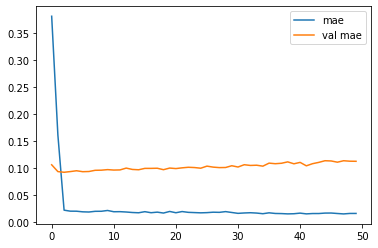

In [71]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [72]:
prediction2_a = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras2_a = pd.DataFrame()
data_new_beras2_a['actual'] = x_test
data_new_beras2_a['prediction'] = data_result2_a

data_new_beras2_a

131/131 [==============================] - 2s 7ms/step
77.63507 0.7274112 91.61441041295032


,actual,prediction
0,10700,10794.753906
1,10700,10794.703125
2,10700,10793.984375
3,10700,10793.987305
4,10700,10794.110352
...,...,...
229,10750,10769.986328
230,10750,10771.228516
231,10700,10769.697266
232,10750,10771.596680


#### Type 2

In [73]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0025 - mae: 0.0321 - val_loss: 0.0337 - val_mae: 0.1630
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0023 - mae: 0.0304 - val_loss: 0.0445 - val_mae: 0.1933
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0021 - mae: 0.0300 - val_loss: 0.0513 - val_mae: 0.2101
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0022 - mae: 0.0295 - val_loss: 0.0520 - val_mae: 0.2118
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0020 - mae: 0.0289 - val_loss: 0.0498 - val_mae: 0.2066
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0021 - mae: 0.0288 - val_loss: 0.0532 - val_mae: 0.2147
Epoch 7/50
718/718 [==============================] - 6s 9ms/step - loss: 0.0020 - mae: 0.0291 - val_loss: 0.0524 - val_mae: 0.2128
Epoch 8/50
718/718 [==============================] - 6s 8ms/step - loss: 0.

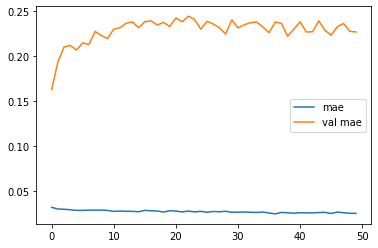

In [74]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
53.440548 0.50001526 65.42193284270192


,actual,prediction
0,10700,10808.412109
1,10700,10804.021484
2,10700,10798.032227
3,10700,10799.821289
4,10700,10805.688477
...,...,...
229,10750,10747.391602
230,10750,10746.614258
231,10700,10745.668945
232,10750,10749.279297


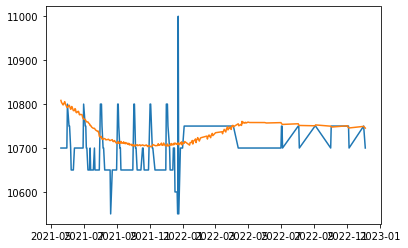

In [80]:
prediction2_a1 = forecast_predict(model2_a, test_beras_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras2_a1 = pd.DataFrame()
data_new_beras2_a1['actual'] = x_test
data_new_beras2_a1['prediction'] = data_result2_a1

plt.plot(y_test, data_new_beras2_a1.actual)
plt.plot(y_test, data_new_beras2_a1.prediction)
data_new_beras2_a1

#### Type 3

In [76]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 1s 14ms/step - loss: 0.0019 - mae: 0.0232 - val_loss: 0.0531 - val_mae: 0.2149
Epoch 2/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0229 - val_loss: 0.0523 - val_mae: 0.2130
Epoch 3/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0226 - val_loss: 0.0502 - val_mae: 0.2080
Epoch 4/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0225 - val_loss: 0.0492 - val_mae: 0.2056
Epoch 5/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0018 - mae: 0.0219 - val_loss: 0.0502 - val_mae: 0.2079
Epoch 6/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0019 - mae: 0.0216 - val_loss: 0.0484 - val_mae: 0.2035
Epoch 7/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0018 - mae: 0.0217 - val_loss: 0.0477 - val_mae: 0.2019
Epoch 8/100
84/84 [==============================] - 1s 12ms/step - loss: 0.

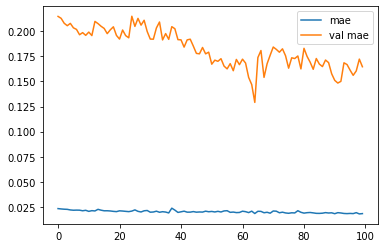

In [77]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 4ms/step
69.55216 0.65125024 83.88873769761946


,actual,prediction
0,10700,10833.237305
1,10700,10830.369141
2,10700,10825.762695
3,10700,10826.682617
4,10700,10830.477539
...,...,...
229,10750,10780.694336
230,10750,10778.775391
231,10700,10779.041992
232,10750,10780.335938


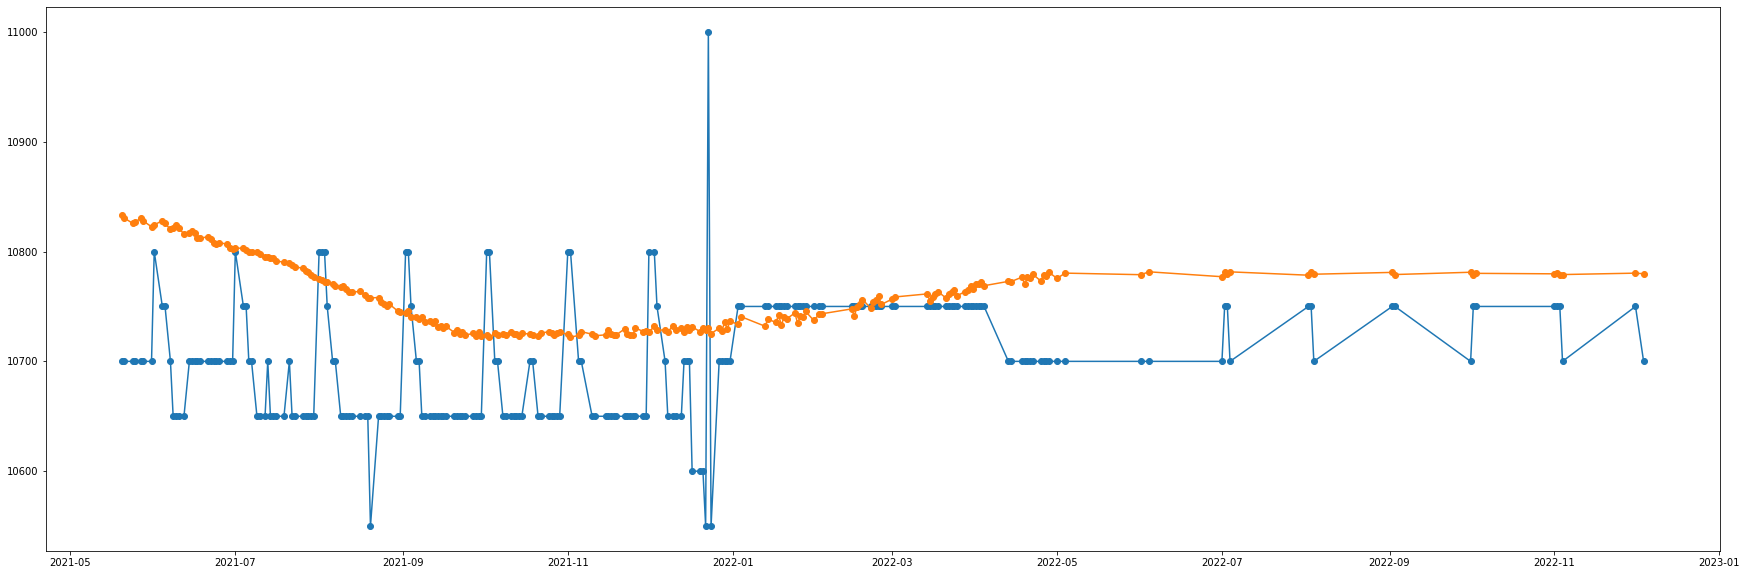

In [78]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras2_a2 = pd.DataFrame()
data_new_beras2_a2['actual'] = x_test
data_new_beras2_a2['prediction'] = data_result2_a2

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras2_a2.actual, '-o')
plt.plot(y_test,data_new_beras2_a2.prediction, '-o')
data_new_beras2_a2